In [35]:
%matplotlib inline

In [36]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [37]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [38]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


In [39]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão DEZ a MAR
print len(df)
df.sample(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
7330895,394,CAMPOS DO JORDÃO,1663.0,-22.750231,-45.603836,A706,Campos do Jordão,SP,2010-12-07 15:00:00,2010-12-07,...,23.8,18.4,21.7,16.3,70.0,77.0,64.0,1.8,285.0,5.4
3448344,340,GOVERNADOR VALADARES,198.0,-18.830354,-41.977007,A532,Governador Valadares,MG,2008-12-31 00:00:00,2008-12-31,...,25.9,21.6,24.3,20.9,78.0,83.0,75.0,1.7,348.0,2.4
2338905,327,CAMPINA VERDE,559.0,-19.539210,-49.518133,A519,Campina Verde,MG,2010-12-02 09:00:00,2010-12-02,...,21.8,20.4,21.7,20.3,92.0,92.0,92.0,1.5,13.0,4.0


In [40]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [41]:
df = df[(df['lat'].between(-20.5,-19.0, inclusive=True)) & 
        (df['lon'].between(-44.5,-43.0, inclusive=True))] 

In [42]:
df.sample(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
1743597,363,IBIRITÈ (ROLA MOÇA),1199.0,-20.031457,-44.011249,A555,Ibirité,MG,2012-01-05 21:00:00,2012-01-05,...,23.5,16.9,21.5,16.2,73.0,73.0,65.0,4.4,70.0,7.4
1799733,370,BELO HORIZONTE - CERCADINHO,1200.0,-19.980034,-43.958651,F501,Belo Horizonte,MG,2016-03-04 21:00:00,2016-03-04,...,18.7,17.7,18.2,17.0,93.0,94.0,92.0,5.3,115.0,9.1
1745658,363,IBIRITÈ (ROLA MOÇA),1199.0,-20.031457,-44.011249,A555,Ibirité,MG,2012-03-31 18:00:00,2012-03-31,...,25.5,17.1,23.1,14.9,60.0,64.0,55.0,2.5,15.0,5.5
1216425,343,FLORESTAL,754.0,-19.885398,-44.416883,A535,Florestal,MG,2011-01-03 09:00:00,2011-01-03,...,19.3,17.9,19.3,17.8,92.0,92.0,91.0,NaN,28.0,2.2


In [43]:
print len(df)

83784


# Pré-processamento

<h3>Dados ausentes</h3>

In [44]:
missing_values_count = (df.isnull().sum()/len(df))*100

In [45]:
missing_values_count[missing_values_count > 0.1]

prcp    86.761195
gbrd    41.876731
wdsp    12.057195
gust     5.879404
dtype: float64

<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [46]:
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [47]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [48]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)

In [49]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

Series([], dtype: float64)

In [50]:
DES = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date','yr','mo','da','hr']

In [51]:
V = [x for x in df.columns if x not in DES]
#df[V].describe().T

<p><b>PRONTO! Dados recuperados!</b> Agora vamos a etapa de limpeza</p>

<h3>Limpeza dos dados</h3>

In [59]:
backup_df = df.copy

<p>Alguns campos podem ser nulos</p>

In [60]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [61]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,80148.0,0.344595,2.054451,0.0,0.0,0.0,0.0,78.4
stp,80148.0,908.432228,19.787321,872.8,883.7,917.0,926.3,935.7
smax,80148.0,908.684077,19.800009,873.0,883.9,917.2,926.6,935.8
smin,80148.0,908.188080,19.782929,872.7,883.5,916.7,926.0,935.7
temp,80148.0,22.559571,3.661378,12.6,19.8,21.8,25.1,36.3
dewp,80148.0,16.989345,1.988470,5.5,15.7,17.1,18.4,23.5
tmax,80148.0,23.249764,3.905134,12.7,20.2,22.4,26.2,37.1
dmax,80148.0,17.583978,1.959501,6.7,16.3,17.7,19.0,24.1
tmin,80148.0,21.909932,3.400696,12.5,19.4,21.2,24.2,34.5
dmin,80148.0,16.428833,2.075802,4.2,15.2,16.6,17.9,22.6


In [62]:
df[cols] = df[cols].replace({0.0:np.nan})

In [63]:
print len(df)
df  = df.dropna()
print len(df)

80148
80148


<p>Verificando os mínimos e máximos</p>

In [65]:
print x[V].describe().T

        count        mean        std    min    25%    50%    75%    max
prcp  80148.0    0.344595   2.054451    0.0    0.0    0.0    0.0   78.4
stp   80148.0  908.432228  19.787321  872.8  883.7  917.0  926.3  935.7
smax  80148.0  908.684077  19.800009  873.0  883.9  917.2  926.6  935.8
smin  80148.0  908.188080  19.782929  872.7  883.5  916.7  926.0  935.7
temp  80148.0   22.559571   3.661378   12.6   19.8   21.8   25.1   36.3
dewp  80148.0   16.989345   1.988470    5.5   15.7   17.1   18.4   23.5
tmax  80148.0   23.249764   3.905134   12.7   20.2   22.4   26.2   37.1
dmax  80148.0   17.583978   1.959501    6.7   16.3   17.7   19.0   24.1
tmin  80148.0   21.909932   3.400696   12.5   19.4   21.2   24.2   34.5
dmin  80148.0   16.428833   2.075802    4.2   15.2   16.6   17.9   22.6
hmdy  80148.0   73.169848  16.856114   20.0   61.0   75.0   88.0   99.0
hmax  80148.0   76.248016  15.583952   23.0   65.0   79.0   90.0   99.0
hmin  80148.0   69.962370  17.870629   13.0   56.0   72.0   86.0

<p>Algumas regras:</p>
<ul>
   <li>Max > Min: para temperatura, humidade, pressão e ponto de orvalho</li>
   <li>Mínima para região é possivel?</li>
   <li>Máxima para região é possivel?</li>
</ul>

<p>Vamos a temperatura máxima e mínima</p>

In [66]:
x = df[(df['tmin'] > df['tmax'])]
print ('tmin>tmax',x)
x = df[(df['hmin'] > df['hmax'])]
print ('hmin>hmax',x)
x = df[(df['smin'] > df['smax'])]
print ('smin>smax',x)
x = df[(df['dmin'] > df['dmax'])]
print ('dmin>dmax',x)

('tmin>tmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('hmin>hmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('smin>smax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])
('dmin>dmax', Empty DataFrame
Columns: [wsid, wsnm, elvt, lat, lon, inme, city, prov, mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 30 columns])


<h4>Outliers</h4>

<p>Usando boxplot para verificar se existem outliers</p> 

In [67]:
sns.set_style("whitegrid")

<p>Pressão atmosférica</p>

In [68]:
sns.set(font_scale=2) 
def bp(var):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    #sns.boxplot(x='prov',y=var, data=df, ax=ax)
    ax = sns.distplot(df[var])
    ax2 = ax.twinx()
    sns.boxplot(x=df[var], ax=ax2)
    ax2.set(ylim=(-.5, 10))
    ax.set_title('Com outliers: ' + var)
def bp_sem(var):
    q = df[var].quantile(0.99)
    x_filt = df[df[var] < q]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    ax = sns.distplot(x_filt[var])    
    ax.set_title('Sem outliers: ' + var)

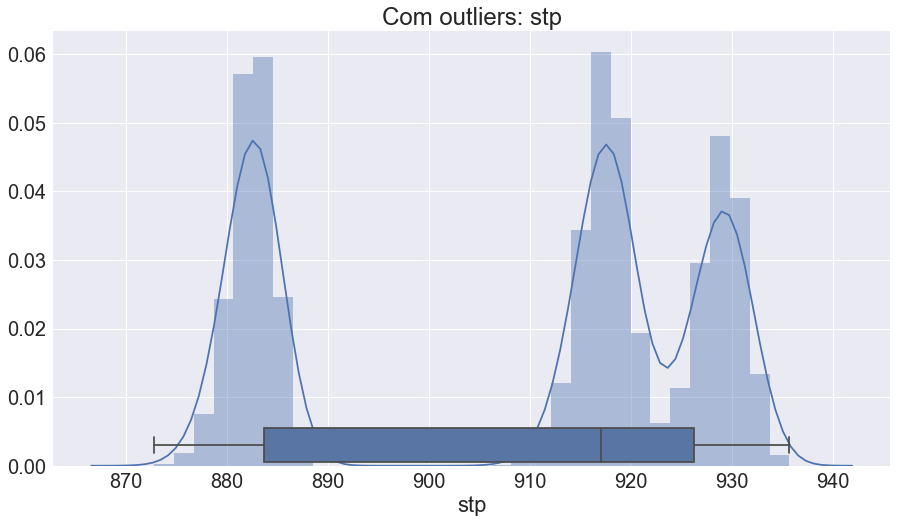

In [69]:
bp('stp')

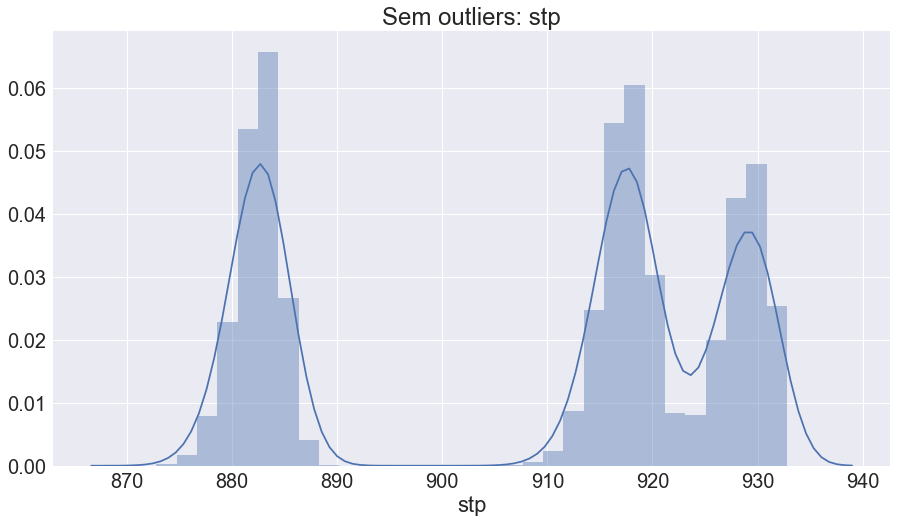

In [70]:
bp_sem('stp')

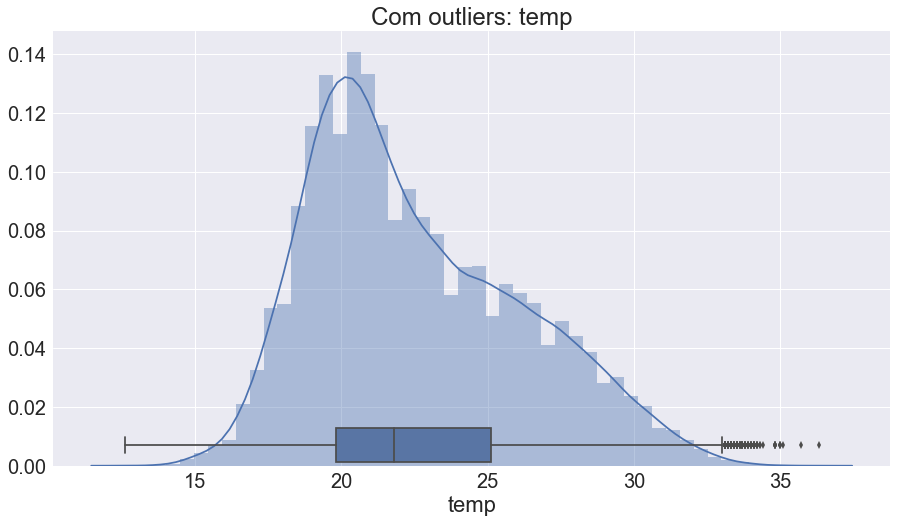

In [71]:
bp('temp')

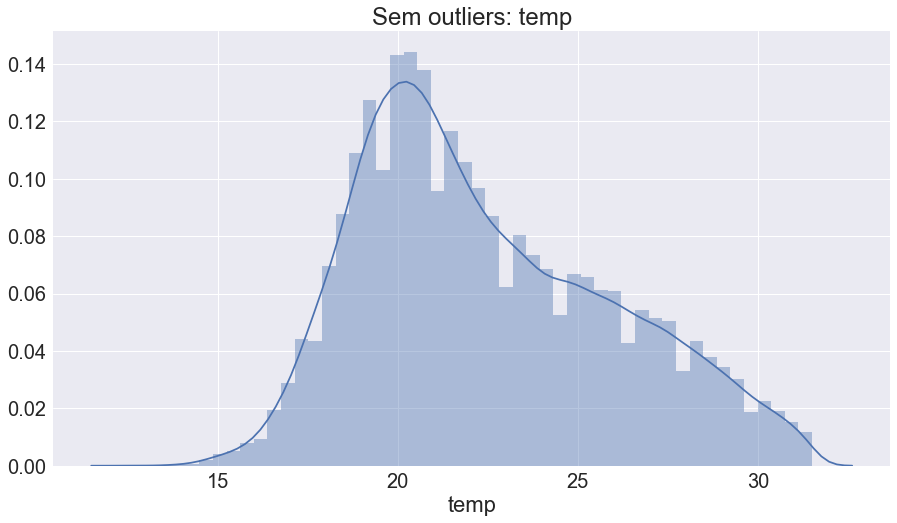

In [72]:
bp_sem('temp')

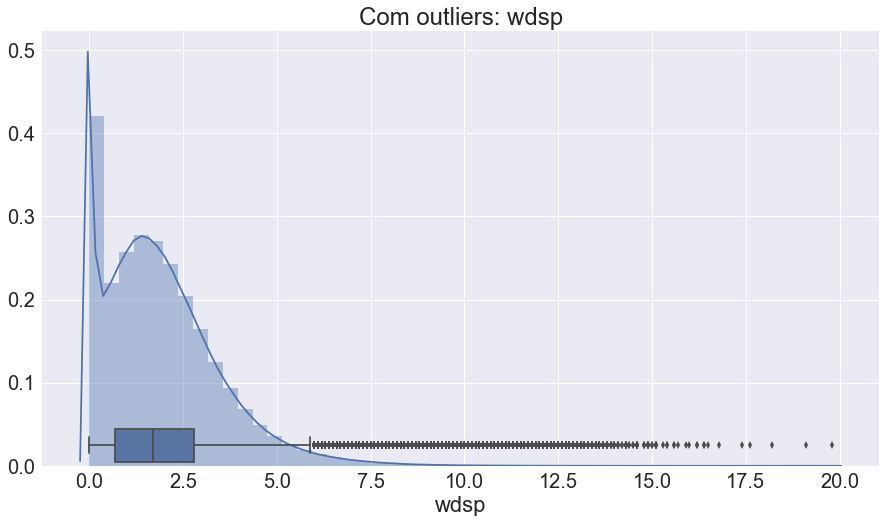

In [102]:
bp('wdsp')

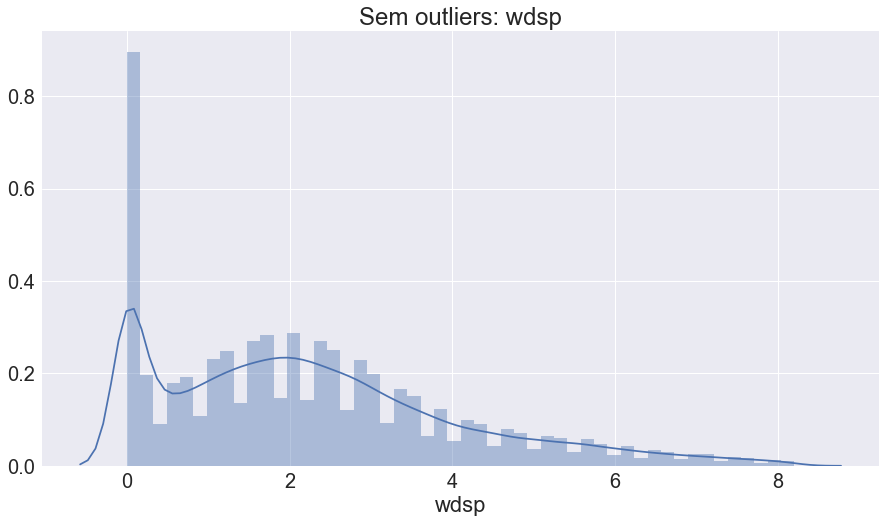

In [73]:
bp_sem('wdsp')

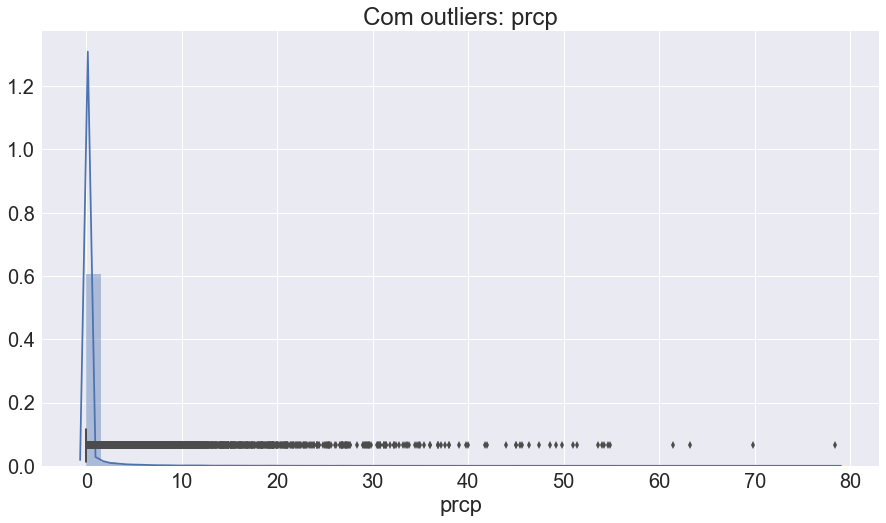

In [74]:
bp('prcp')

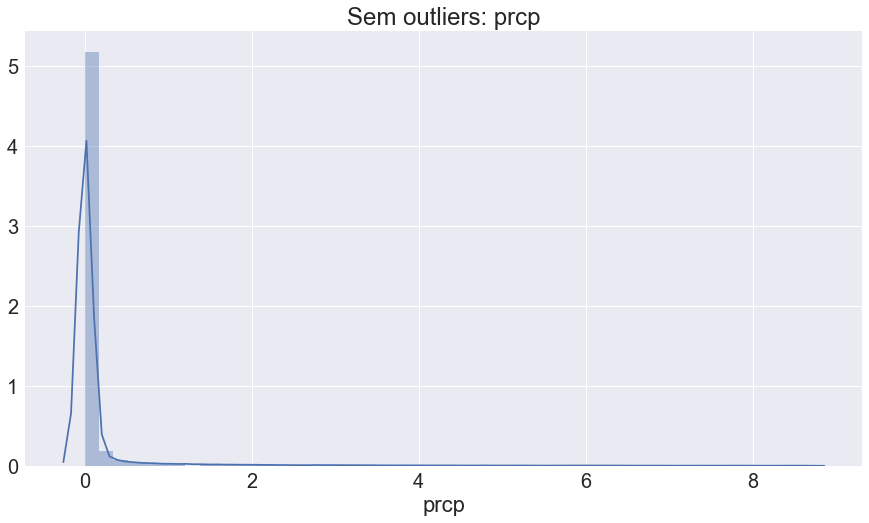

In [75]:
bp_sem('prcp')

<h3>Derivando novas variáveis (Feature engineering)</h3>

<p>Recuperando o backup do dataframe antes da limpeza dos nulos, pois preciso derivar as freatures primeiro.
Assim, após a derivá-las, irei apagar os que não pode ser nulo. Esta etapa teve que ser feita de novo, por este motivo</p> 

In [76]:
dfm = backup_df() 

In [77]:
len(dfm)

80148

In [78]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.sample(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
835332,329,854.0,-19.883945,-43.969397,2013-01-14 12:00:00,0.0,919.7,919.7,919.2,23.5,...,23.9,16.7,22.5,14.7,61.0,68.0,58.0,3.5,74.0,9.0
830550,329,854.0,-19.883945,-43.969397,2011-02-27 06:00:00,0.0,914.6,914.9,914.6,21.0,...,21.7,19.4,20.9,18.6,87.0,88.0,85.0,1.0,67.0,2.7
1738898,363,1199.0,-20.031457,-44.011249,2010-02-21 02:00:00,0.0,884.9,884.9,884.7,21.5,...,22.0,16.8,21.4,16.5,74.0,74.0,71.0,4.1,95.0,10.1
1228875,343,754.0,-19.885398,-44.416883,2015-02-06 03:00:00,0.0,926.4,926.9,926.4,19.6,...,19.8,18.7,19.6,18.3,92.0,94.0,92.0,2.6,349.0,6.0
1752502,363,1199.0,-20.031457,-44.011249,2015-01-12 22:00:00,0.0,883.3,883.3,883.0,25.4,...,27.3,11.7,25.0,11.0,41.0,43.0,37.0,4.6,66.0,8.5


In [79]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print ws

[329, 343, 363, 370]


In [80]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [81]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,6,NON_DER)

In [82]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [83]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [84]:
dfr.sample(3)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_3,dmax_4,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6
1753678,363,1199.0,-20.031457,-44.011249,2015-03-02 22:00:00,0.0,883.1,883.2,882.8,20.7,...,16.1,16.6,16.0,16.5,0.0,0.0,0.0,0.0,0.0,0.0
1800187,370,1200.0,-19.980034,-43.958651,2016-03-23 19:00:00,0.2,880.7,881.0,880.5,21.4,...,18.3,18.3,18.0,17.7,1.0,0.0,0.0,0.0,0.0,0.0
1734215,363,1199.0,-20.031457,-44.011249,2008-12-08 23:00:00,9.0,884.8,885.6,884.7,17.3,...,15.7,15.7,16.6,15.9,13.4,0.0,0.6,0.0,0.0,0.0


In [85]:
dfr.columns

Index([u'wsid', u'elvt', u'lat', u'lon', u'mdct', u'prcp', u'stp', u'smax',
       u'smin', u'temp',
       ...
       u'dmax_3', u'dmax_4', u'dmax_5', u'dmax_6', u'prcp_1', u'prcp_2',
       u'prcp_3', u'prcp_4', u'prcp_5', u'prcp_6'],
      dtype='object', length=123)

In [86]:
dfm = dfr

In [87]:
list(dfm.columns)

['wsid',
 'elvt',
 'lat',
 'lon',
 'mdct',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 '

In [88]:
len(dfm)

80148

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [89]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES + ['temp']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [90]:
dfm[cols] = dfm[cols].replace({0.0:np.nan}) 

In [91]:
print len(dfm)
dfm  = dfm.dropna()
print len(dfm)

80148
80142


In [92]:
dfm = dfm.reset_index(drop=True)

In [93]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_3,dmax_4,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6
0,329,854.0,-19.883945,-43.969397,2006-12-01 06:00:00,0.0,913.5,913.8,913.4,20.8,...,20.5,20.6,20.6,20.5,0.6,12.4,1.8,0.4,0.0,0.0
1,329,854.0,-19.883945,-43.969397,2006-12-01 07:00:00,0.0,913.4,913.6,913.4,20.2,...,20.4,20.5,20.6,20.6,0.0,0.6,12.4,1.8,0.4,0.0
2,329,854.0,-19.883945,-43.969397,2006-12-01 08:00:00,0.0,914.2,914.2,913.4,20.1,...,20.1,20.4,20.5,20.6,0.0,0.0,0.6,12.4,1.8,0.4
3,329,854.0,-19.883945,-43.969397,2006-12-01 09:00:00,0.0,915.0,915.0,914.2,20.7,...,19.6,20.1,20.4,20.5,0.0,0.0,0.0,0.6,12.4,1.8
4,329,854.0,-19.883945,-43.969397,2006-12-01 10:00:00,0.0,915.7,915.7,915.0,21.3,...,19.7,19.6,20.1,20.4,0.0,0.0,0.0,0.0,0.6,12.4


In [94]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80142 entries, 0 to 80141
Columns: 123 entries, wsid to prcp_6
dtypes: float64(115), int64(1), object(7)
memory usage: 75.2+ MB


In [95]:
dfm = dfm.drop('wsid',1)
dfm = dfm.drop('mdct',1)

In [96]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',


In [97]:
REMOVE = [u'mdct',u'mdct_1', u'mdct_2', u'mdct_3', u'mdct_4', u'mdct_5', u'mdct_6']
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

In [98]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'smin_1',
 'smin_2',
 'smin_3',
 'smin_4',
 '

<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [99]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [100]:
target = 'temp'

In [101]:
X =  dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [104]:
list(X.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'dewp',
 'tmax',
 'dmax',
 'tmin',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'smin_1',
 'smin_2',
 'smin_3',
 'smin_4',
 '

In [105]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.1, random_state=12) 
print len(X_train)
print len(X_tmp)

72127
8015


<p>Separando o conjunto de testes</p>

In [106]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2)

In [107]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   72127, Training features   115
Validation instances 1603, Validation features 115
Testing instances    6412, Testing features    115


In [108]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [109]:
Z = X.copy()
Z.pop(target)
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [111]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      #,activation_fn=activation_fn
                                      ,model_dir='/tmp/tf_model_04')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1152b40d0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_model_04', '_save_summary_steps': 100}


In [112]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [113]:
evaluations = []  
STEPS = 500  

for i in range(1, up):
    
    regressor.train(
        input_fn=wx_input_fn(X_train
                            ,y_train)
        , steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(X_val
                                                ,y_val
                                                ,num_epochs=1
                                                ,shuffle=False)))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:loss = 1657894.6, step = 1
INFO:tensorflow:global_step/sec: 4.54442
INFO:tensorflow:loss = 57150.664, step = 101 (22.006 sec)
INFO:tensorflow:global_step/sec: 3.66999
INFO:tensorflow:loss = 47606.113, step = 201 (27.248 sec)
INFO:tensorflow:global_step/sec: 4.38326
INFO:tensorflow:loss = 42603.77, step = 301 (22.814 sec)
INFO:tensorflow:global_step/sec: 4.43261
INFO:tensorflow:loss = 36812.6, step = 401 (22.559 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:Loss for final step: 32062.465.
INFO:tensorflow:Starting evaluation at 2018-04-06-12:29:04
INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-500
INFO:tensorflow:Finished evaluation at 2018-04-06-12:29:06
INFO:tensorflow:Saving dict for global step 500: average_loss = 31.5535, global_step = 500, loss = 25290.129
INFO:tensorflow:Cre

INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-4000
INFO:tensorflow:Finished evaluation at 2018-04-06-12:39:12
INFO:tensorflow:Saving dict for global step 4000: average_loss = 3.935141, global_step = 4000, loss = 3154.0156
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-4000
INFO:tensorflow:Saving checkpoints for 4001 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:loss = 3963.0132, step = 4001
INFO:tensorflow:global_step/sec: 7.67528
INFO:tensorflow:loss = 3020.9463, step = 4101 (13.030 sec)
INFO:tensorflow:global_step/sec: 6.34425
INFO:tensorflow:loss = 2525.3962, step = 4201 (15.762 sec)
INFO:tensorflow:global_step/sec: 5.18207
INFO:tensorflow:loss = 4301.025, step = 4301 (19.297 sec)
INFO:tensorflow:global_step/sec: 4.43728
INFO:tensorflow:loss = 2531.898, step = 4401 (22.536 sec)
INFO:tensorflow:Saving checkpoints for 4500 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:Loss for final step

INFO:tensorflow:global_step/sec: 5.00178
INFO:tensorflow:loss = 2591.3345, step = 7801 (19.993 sec)
INFO:tensorflow:global_step/sec: 4.27142
INFO:tensorflow:loss = 1713.8436, step = 7901 (23.411 sec)
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:Loss for final step: 1965.5525.
INFO:tensorflow:Starting evaluation at 2018-04-06-12:56:16
INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-8000
INFO:tensorflow:Finished evaluation at 2018-04-06-12:56:17
INFO:tensorflow:Saving dict for global step 8000: average_loss = 2.0036416, global_step = 8000, loss = 1605.9188
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-8000
INFO:tensorflow:Saving checkpoints for 8001 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:loss = 1973.3385, step = 8001
INFO:tensorflow:global_step/sec: 7.17479
INFO:tensorflow:loss = 1692.9674, step = 8101 (13.939 sec)
INFO:tensorflow:global_st

INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-11500
INFO:tensorflow:Saving checkpoints for 11501 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:loss = 1275.2789, step = 11501
INFO:tensorflow:global_step/sec: 8.28963
INFO:tensorflow:loss = 1369.0142, step = 11601 (12.065 sec)
INFO:tensorflow:global_step/sec: 8.34655
INFO:tensorflow:loss = 1421.2289, step = 11701 (11.981 sec)
INFO:tensorflow:global_step/sec: 8.50093
INFO:tensorflow:loss = 1434.7035, step = 11801 (11.763 sec)
INFO:tensorflow:global_step/sec: 8.40452
INFO:tensorflow:loss = 1882.6561, step = 11901 (11.899 sec)
INFO:tensorflow:Saving checkpoints for 12000 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:Loss for final step: 1343.0526.
INFO:tensorflow:Starting evaluation at 2018-04-06-13:07:11
INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-12000
INFO:tensorflow:Finished evaluation at 2018-04-06-13:07:13
INFO:tensorflow:Saving dict for global step 12000: average_loss = 1.31394

INFO:tensorflow:Loss for final step: 1322.277.
INFO:tensorflow:Starting evaluation at 2018-04-06-13:16:10
INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-15500
INFO:tensorflow:Finished evaluation at 2018-04-06-13:16:12
INFO:tensorflow:Saving dict for global step 15500: average_loss = 1.3268193, global_step = 15500, loss = 1063.4457
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-15500
INFO:tensorflow:Saving checkpoints for 15501 into /tmp/tf_model_04/model.ckpt.
INFO:tensorflow:loss = 1436.1771, step = 15501
INFO:tensorflow:global_step/sec: 8.42985
INFO:tensorflow:loss = 1069.6669, step = 15601 (11.866 sec)
INFO:tensorflow:global_step/sec: 8.5231
INFO:tensorflow:loss = 1468.1907, step = 15701 (11.733 sec)
INFO:tensorflow:global_step/sec: 8.52863
INFO:tensorflow:loss = 2131.5718, step = 15801 (11.725 sec)
INFO:tensorflow:global_step/sec: 8.51087
INFO:tensorflow:loss = 1080.8833, step = 15901 (11.750 

INFO:tensorflow:loss = 1514.251, step = 19101 (13.105 sec)


KeyboardInterrupt: 

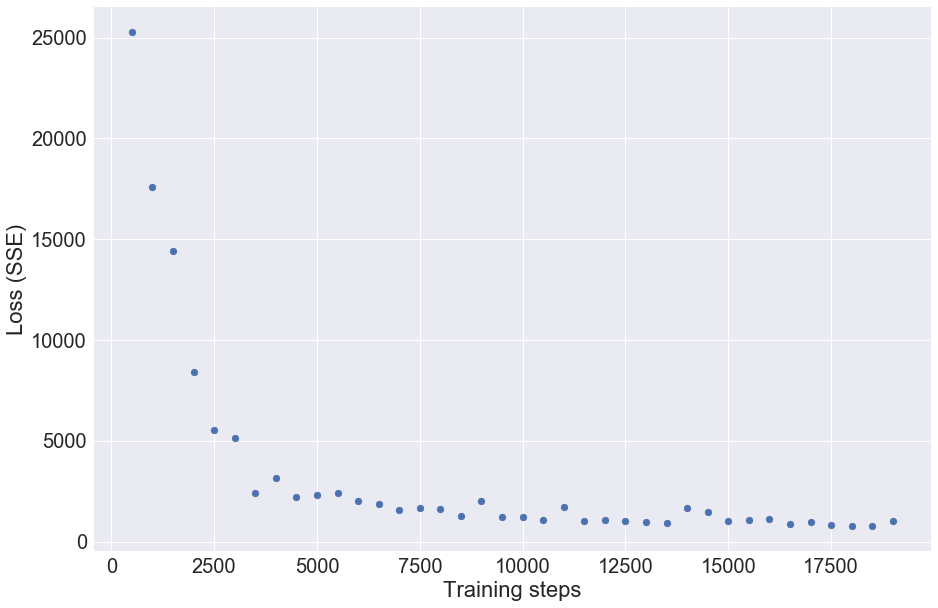

In [114]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [115]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Restoring parameters from /tmp/tf_model_04/model.ckpt-19001


In [116]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.93
The Mean Absolute Error: 0.87 
The Median Absolute Error: 0.73 


In [117]:
predictions

array([26.373394, 22.605726, 29.555151, ..., 19.514414, 23.440613,
       22.681004], dtype=float32)

In [118]:
predictions.size

6412

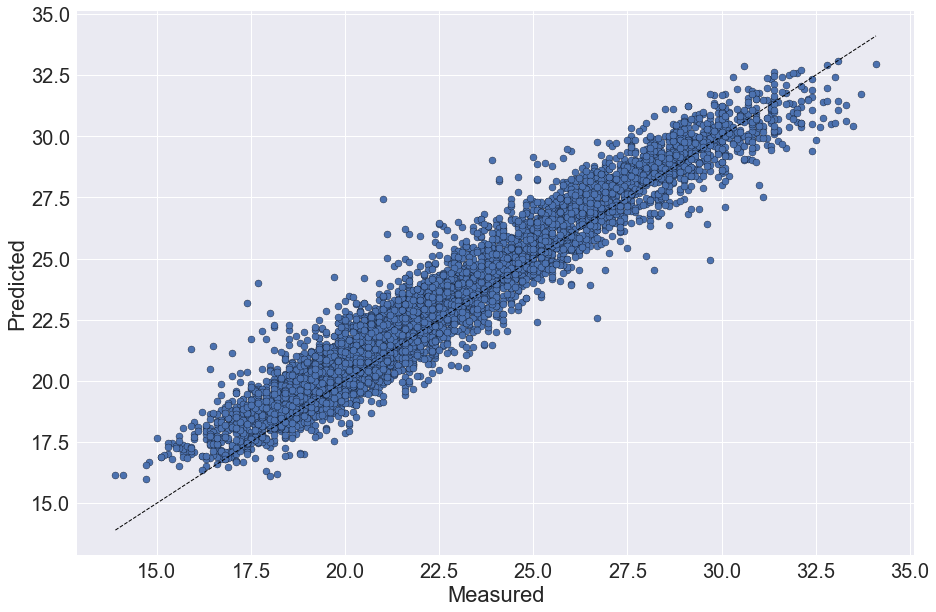

In [119]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()